In [1]:
# %% [markdown]
# # 03 – Model Exploration
#
# In this notebook we:
# 1. Load processed train / test splits
# 2. Train baseline models (Logistic, RF, XGBoost)
# 3. Tune with RandomizedSearchCV
# 4. Visualize results using shared plotting utilities


In [2]:
# %% [code]
import sys
import os
from pathlib import Path

# Resolve repo root reliably (Jupyter + scripts)
try:
    repo_root = Path(__file__).resolve().parents[1]
except NameError:
    repo_root = Path(os.getcwd()).resolve().parent

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Project code
from src.pipelines.churn_pipeline import get_churn_pipeline
from src.features.preprocessing import identify_feature_types
from src.visualization.plots import (
    plot_roc_curve,
    plot_confusion_matrix,
    plot_feature_importance,
)
from src.utils.logger import get_logger

logger = get_logger(__name__)


In [3]:
# %% [code]
DATA_ROOT = repo_root / "data" / "processed"

X_train = pd.read_parquet(DATA_ROOT / "X_train.parquet")
X_test  = pd.read_parquet(DATA_ROOT / "X_test.parquet")

def load_target(path):
    y_raw = pd.read_parquet(path)["Churn"]
    y = (
        y_raw.astype(str)
        .str.strip()
        .str.lower()
        .map({
            "yes": 1,
            "no": 0,
            "true": 1,
            "false": 0,
            "1": 1,
            "0": 0,
        })
    )
    assert y.nunique() == 2, f"Target invalid: {y.value_counts()}"
    return y.astype(int)

y_train = load_target(DATA_ROOT / "y_train.parquet")
y_test  = load_target(DATA_ROOT / "y_test.parquet")

logger.info(
    f"Data loaded | X_train: {X_train.shape}, "
    f"X_test: {X_test.shape}, "
    f"y_train distribution:\n{y_train.value_counts()}"
)


2026-01-09 03:03:15,967 - __main__ - INFO - Data loaded | X_train: (5634, 32), X_test: (1409, 32), y_train distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64


In [4]:
# %% [code]
numeric_features, categorical_features = identify_feature_types(
    X_train, target_col="Churn"
)


In [5]:
# %% [code]
estimators = {
    "logistic_regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear",
        random_state=42,
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    ),
    "xgboost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    ),
}

param_grids = {
    "logistic_regression": {
        "model__C": np.logspace(-3, 3, 7)
    },
    "random_forest": {
        "model__max_depth": [5, 10, None],
        "model__min_samples_split": [2, 5, 10],
    },
    "xgboost": {
        "model__max_depth": [3, 5, 7],
        "model__subsample": [0.7, 0.9, 1.0],
    },
}


In [6]:
# %% [code]
def train_evaluate(name, estimator, param_grid):
    logger.info(f"Tuning {name}...")

    pipeline = get_churn_pipeline(
        model=estimator,
        numeric_features=numeric_features,
        categorical_features=categorical_features,
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        pipeline,
        param_grid,
        n_iter=5,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        random_state=42,
        error_score="raise",
    )

    search.fit(X_train, y_train)

    best_pipe = search.best_estimator_
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
    }

    return best_pipe, metrics, y_proba, y_pred


In [ ]:
# %% [code]
results = {}

for name, estimator in estimators.items():
    pipe, metrics, y_proba, y_pred = train_evaluate(
        name, estimator, param_grids[name]
    )
    results[name] = {
        "pipeline": pipe,
        "metrics": metrics,
        "y_proba": y_proba,
        "y_pred": y_pred,
    }


2026-01-09 03:03:16,102 - __main__ - INFO - Tuning logistic_regression...
2026-01-09 03:03:16,105 - src.features.preprocessing - INFO - Preprocessor created with 15 numeric and 17 categorical features.
2026-01-09 03:03:16,107 - src.pipelines.churn_pipeline - INFO - Created churn pipeline with model LogisticRegression


2026-01-09 03:03:30,898 - __main__ - INFO - Tuning random_forest...
2026-01-09 03:03:30,970 - src.features.preprocessing - INFO - Preprocessor created with 15 numeric and 17 categorical features.
2026-01-09 03:03:30,973 - src.pipelines.churn_pipeline - INFO - Created churn pipeline with model RandomForestClassifier
2026-01-09 03:03:47,654 - __main__ - INFO - Tuning xgboost...
2026-01-09 03:03:47,661 - src.features.preprocessing - INFO - Preprocessor created with 15 numeric and 17 categorical features.
2026-01-09 03:03:47,663 - src.pipelines.churn_pipeline - INFO - Created churn pipeline with model XGBClassifier


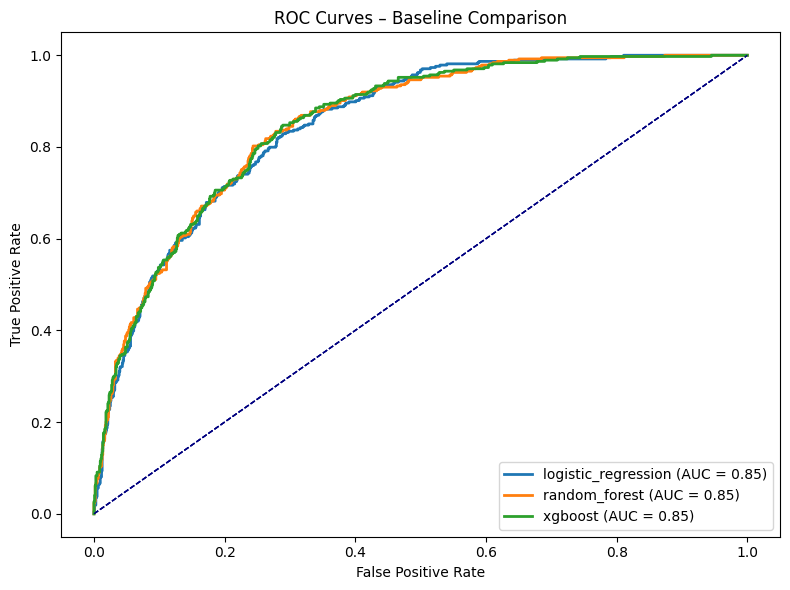

In [ ]:
# %% [code]
plt.figure(figsize=(8, 6))
for name, r in results.items():
    plot_roc_curve(y_test, r["y_proba"], model_name=name, ax=plt.gca())

plt.title("ROC Curves – Baseline Comparison")
plt.tight_layout()
plt.show()


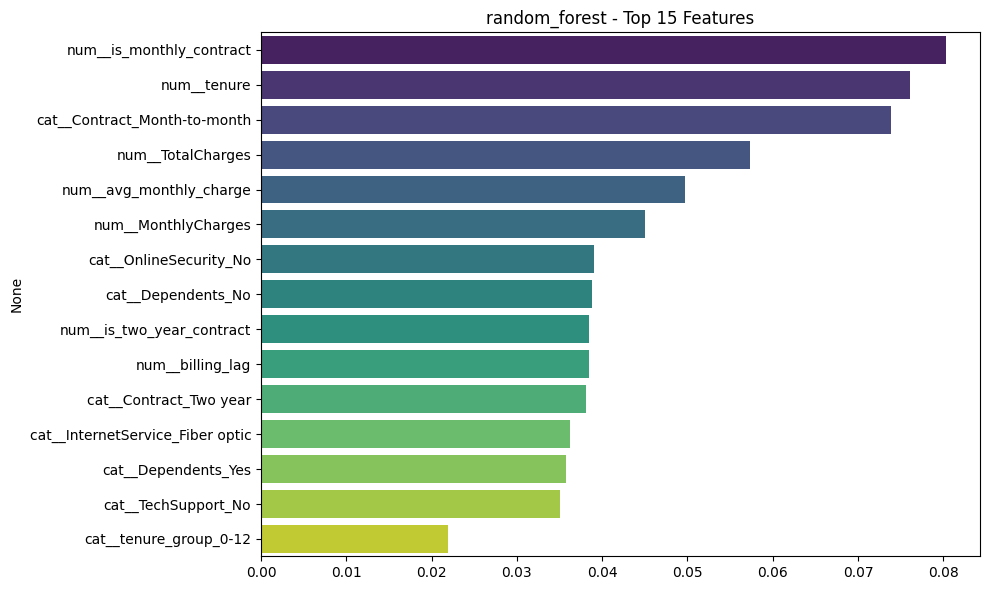

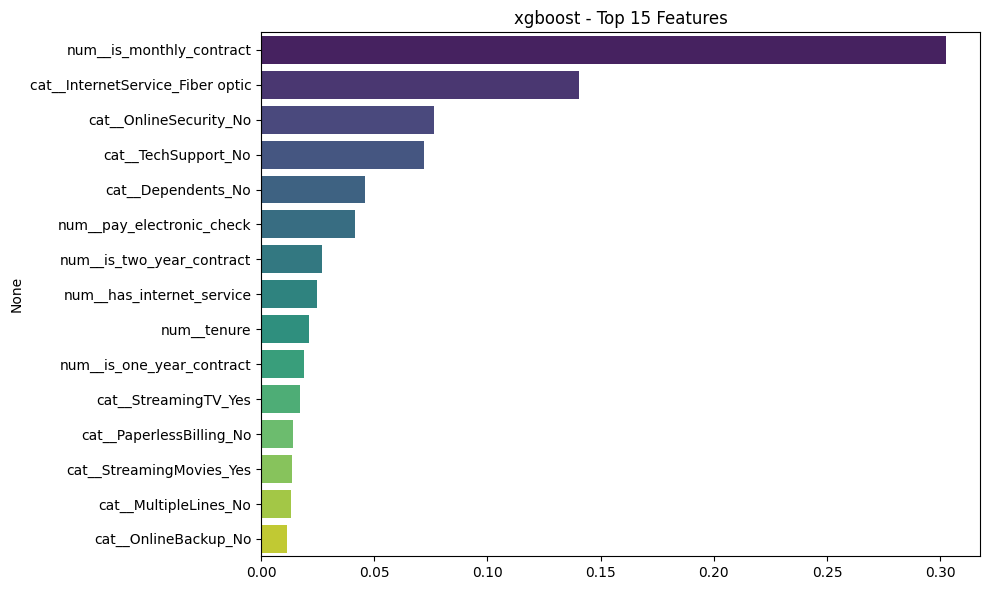

In [ ]:
# %% [code]
for name in ["random_forest", "xgboost"]:
    pipe = results[name]["pipeline"]
    model = pipe.named_steps["model"]
    feature_names = pipe.named_steps["preprocess"].get_feature_names_out()


    plot_feature_importance(
        model,
        feature_names,
        model_name=name,
    )


In [ ]:
# %% [code]
summary = pd.DataFrame(
    {name: r["metrics"] for name, r in results.items()}
).T

display(summary.round(3))


,accuracy,precision,recall,roc_auc
logistic_regression,0.752,0.522,0.791,0.849
random_forest,0.768,0.547,0.735,0.852
xgboost,0.803,0.656,0.540,0.852
